In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from colour import Color
import matplotlib.ticker as mtick

db_filename = 'dinofunworld.db'
conn = sqlite3.connect(db_filename)
c = conn.cursor()

In [2]:
# Creat a pandas dataframe of 'checkin' table

sql_query = """SELECT * FROM checkin;"""
c.execute(sql_query)

df_checkin = pd.DataFrame(c.fetchall(), columns = ['index', 'visitorID', 'timestamp', 'AttractionID', 'duration', 'type'])
df_checkin.drop('index', axis=1, inplace=True)

In [3]:
# Creat a pandas dataframe of 'attraction' table

sql_query = """SELECT * FROM attraction;"""
c.execute(sql_query)

df_attraction = pd.DataFrame(c.fetchall(), columns = ['index', 'AttractionID', 'Name', 'Region', 'Category', 'type'])
df_attraction.drop('index', axis=1, inplace=True)
#df_attraction_Category_count = df_attraction["Category"].value_counts()

In [4]:
# Creat a pandas dataframe of 'sequences' table

sql_query = """SELECT * FROM sequences;"""
c.execute(sql_query)

df_sequences = pd.DataFrame(c.fetchall(), columns = ['index', 'visitorID', 'sequence'])
df_sequences.drop('index', axis=1, inplace=True)

In [5]:
# Join 'checkin' and 'attraction' tables to get the information we'll use for plotting charts

df_checkin['Category'] = df_checkin.AttractionID.map(df_attraction.set_index('AttractionID')['Category'].to_dict())
df_checkin['AttractionName'] = df_checkin.AttractionID.map(df_attraction.set_index('AttractionID')['Name'].to_dict())


Data used to generate chart:
[['Atmosfear', 27747], ['Keimosaurus Big Spin', 18792], ['Galactosaurus Rage', 18717], ['Wrightiraptor Mountain', 18700], ['Auvilotops Express', 18694], ['Flight of the Swingodon', 16093], ['Firefall', 16024], ['Wendisaurus Chase', 15577], ['TerrorSaur', 14415]]


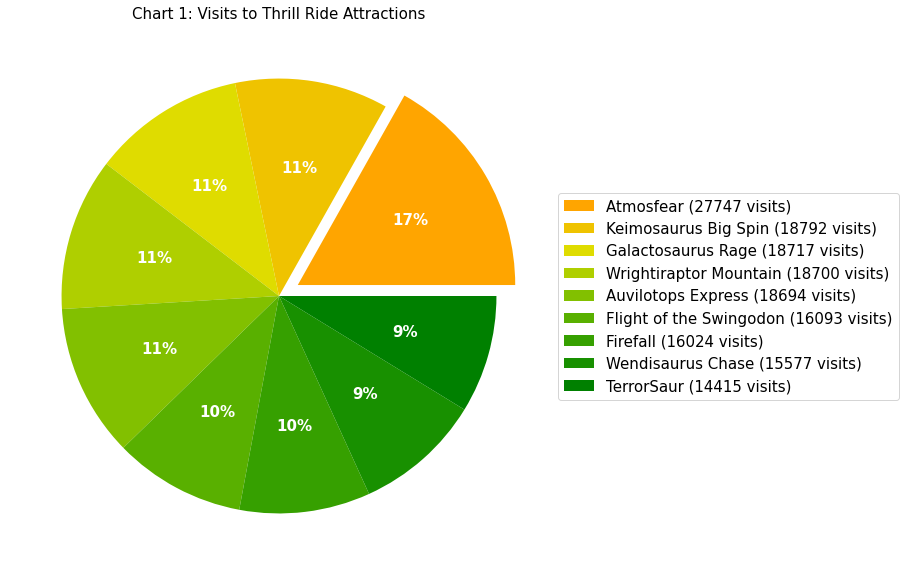

In [6]:
# Chart 1: A Pie Chart depicting visits to thrill ride attractions.
# Extract rows that relate to thrill ride attractions

thrill_ride_record = df_checkin.loc[df_checkin['Category'].str.contains('Thrill Rides')]
thrill_ride_record = thrill_ride_record[["AttractionName"]]
thrill_ride_record_count = thrill_ride_record["AttractionName"].value_counts()
thrill_ride_record = thrill_ride_record[["AttractionName"]].value_counts().reset_index()
thrill_ride_record.columns = ['AttractionName', 'Visit']
print("Data used to generate chart:")
print(thrill_ride_record.values.tolist())

# Create the pie chart for visits to thrill ride attractions
fig, ax = plt.subplots()

explode = tuple(0 for _ in range(len(thrill_ride_record_count)))
explode_list = list(explode)
explode_list[0] = 0.1
explode = tuple(explode_list)

orange = Color("orange")
colors = list(orange.range_to(Color("green"),len(thrill_ride_record_count)))
colors = [color.rgb for color in colors]
ax = thrill_ride_record_count.plot(ax = ax, kind='pie', explode=explode, labels=None, autopct='%1.0f%%', colors=colors, figsize=(15,10), textprops={'fontsize':15, 'color':"w", 'weight':'bold'})
ax.set_ylabel('')

# Set the title

ax.set_title("Chart 1: Visits to Thrill Ride Attractions", fontsize=15)
legend_labels = [f'{l} ({s} visits)' for l, s in zip(thrill_ride_record['AttractionName'], thrill_ride_record['Visit'])]
ax.legend(legend_labels,loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)

fig.savefig('Chart 1.png', bbox_inches='tight')

Data used to generate chart:
[['Ice Age Cones', 3228], ['Floral Funnels', 3083], ['Chensational Sweets', 3049], ['Smoky Wood BBQ', 3037], ['EberTrex Fries', 3018], ['Permafrosties', 3018], ['Plaisantly Popped Corn', 2914], ['Granite Slab Pizza', 2810], ['Krystal Cook Cafe', 1725], ["Shilobite o'Pizza", 1393], ['Paleo Shreckwiches', 1361], ['Theresaur Food Stop', 1116]]


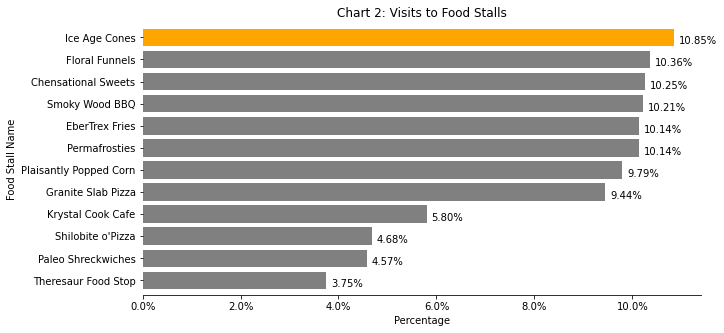

In [7]:
# Chart 2: A Bar Chart depicting total visits to food stalls.
# Extract rows that relate to food

food_record = df_checkin.loc[df_checkin['Category'].str.contains('Food')]
food_record = food_record[["AttractionName"]]
food_record_count = food_record["AttractionName"].value_counts()
food_record = food_record[["AttractionName"]].value_counts().reset_index()
food_record.columns = ['Food Stall Name', 'Visit']
print("Data used to generate chart:")
print(food_record.values.tolist())
food_record['Percentage'] = (food_record['Visit']/food_record['Visit'].sum()) * 100


# Create the bar chart for visits to food stalls
# Mark the food stall that was most visited as orange
fig, ax = plt.subplots()

colors = ['grey' if (x < max(food_record['Percentage'])) else 'orange' for x in food_record['Percentage'] ]
ax = food_record.plot(ax = ax, kind='barh', x="Food Stall Name", y="Percentage", edgecolor = "none", width=0.8, color=colors, figsize=(10,5))
ax.set_xlabel('Percentage')
ax.invert_yaxis()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set the title

ax.set_title("Chart 2: Visits to Food Stalls")
ax.get_legend().remove()

# Add detailed numbers in each bar

ax.xaxis.set_major_formatter(mtick.PercentFormatter())
idx = 0   
for value in ax.patches:
        ax.text(value.get_width()+0.1, value.get_y()+value.get_height(),
                "%.02f%%" % food_record.at[idx,'Percentage'],
                ha='left', va='bottom', rotation=0, color='black')
        idx = idx + 1
fig.savefig('Chart 2.png', bbox_inches='tight')

In [8]:
# Chart 3: A Line Chart depicting attendance at the newest ride, Atmosfear over the course of the day.

import numpy as np
import matplotlib.dates as md

Atmosfear_record = df_checkin.loc[df_checkin['AttractionName'].str.contains('Atmosfear')]
Atmosfear_record = Atmosfear_record.sort_values(['timestamp'])

# convert to datetime
Atmosfear_record['timestamp'] = pd.to_datetime(Atmosfear_record['timestamp'])

Atmosfear_ID = df_attraction.loc[df_attraction['Name'] == "Atmosfear", 'AttractionID'].iloc[0]
first_day_record_by_hour = pd.DataFrame()
for i in range(df_sequences.shape[0]):    
    firstday = df_sequences['sequence'][i].split('-')[0:192]
    if str(Atmosfear_ID) in firstday:
        for x in range(len(firstday)):
            if firstday[x] != str(Atmosfear_ID):
                firstday[x] = '0'
        first_day_record_by_hour = pd.concat([first_day_record_by_hour, pd.DataFrame(firstday)], axis=1, ignore_index=True)


In [9]:
first_day_record_by_hour = first_day_record_by_hour.T

In [10]:
used_list = []
timeslot = 0

for (columnName, columnData) in first_day_record_by_hour.iteritems():
    tuple_temp = (timeslot, 2725-columnData.value_counts()[0])
    used_list.append(tuple_temp)
    timeslot = timeslot+1
print("Used list for chart 3: ")
print(used_list)

Used list for chart 3: 
[(0, 0), (1, 0), (2, 9), (3, 19), (4, 49), (5, 62), (6, 46), (7, 44), (8, 33), (9, 75), (10, 81), (11, 98), (12, 75), (13, 89), (14, 80), (15, 85), (16, 52), (17, 82), (18, 80), (19, 103), (20, 108), (21, 93), (22, 68), (23, 90), (24, 89), (25, 117), (26, 108), (27, 81), (28, 89), (29, 94), (30, 87), (31, 85), (32, 82), (33, 97), (34, 100), (35, 137), (36, 142), (37, 134), (38, 109), (39, 138), (40, 142), (41, 157), (42, 164), (43, 176), (44, 78), (45, 73), (46, 62), (47, 77), (48, 73), (49, 99), (50, 118), (51, 109), (52, 108), (53, 106), (54, 100), (55, 134), (56, 90), (57, 83), (58, 78), (59, 96), (60, 95), (61, 102), (62, 133), (63, 97), (64, 110), (65, 121), (66, 134), (67, 102), (68, 101), (69, 114), (70, 103), (71, 123), (72, 87), (73, 111), (74, 140), (75, 129), (76, 103), (77, 94), (78, 53), (79, 43), (80, 53), (81, 76), (82, 78), (83, 53), (84, 73), (85, 82), (86, 104), (87, 91), (88, 84), (89, 89), (90, 81), (91, 64), (92, 65), (93, 70), (94, 80), (95

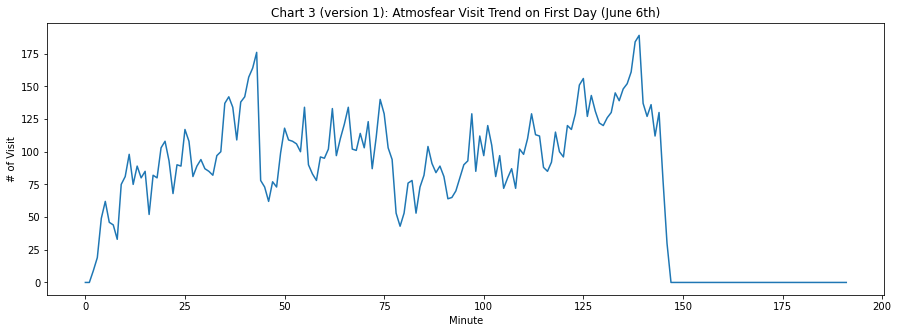

In [11]:
fig, ax = plt.subplots()

ax.plot(*zip(*used_list))
ax.set_title('Chart 3 (version 1): Atmosfear Visit Trend on First Day (June 6th)')
ax.set_xlabel('Minute')
ax.set_ylabel('# of Visit')
fig.set_size_inches(15, 5)
fig.savefig('Chart 3 (version 1).png', bbox_inches='tight')

In [12]:
# Chart 3 - Version 2
# Separate the visit by date
# Jun. 6th

junsixth = Atmosfear_record[Atmosfear_record['timestamp'] < pd.Timestamp(2014, 6, 7)]
junsixth = junsixth.groupby(junsixth.timestamp.dt.floor('1H')).count()
junsixth = junsixth[['visitorID']]
junsixth.columns = ['Visit']

junsixth['Time'] = junsixth.index.time
junsixth.set_index('Time', inplace=True, drop=True)

In [13]:
# Jun. 7th

junseventh = Atmosfear_record[Atmosfear_record['timestamp'].between(pd.Timestamp(2014, 6, 7), pd.Timestamp(2014, 6, 8))]
junseventh = junseventh.groupby(junseventh.timestamp.dt.floor('1H')).count()
junseventh = junseventh[['visitorID']]
junseventh.columns = ['Visit']
junseventh['Time'] = junseventh.index.time
junseventh.set_index('Time', inplace=True, drop=True)

In [14]:
# Jun. 8th

juneighth = Atmosfear_record[Atmosfear_record['timestamp'].between(pd.Timestamp(2014, 6, 8), pd.Timestamp(2014, 6, 9))]
juneighth = juneighth.groupby(Atmosfear_record.timestamp.dt.floor('1H')).count()
juneighth = juneighth[['visitorID']]
juneighth.columns = ['Visit']
juneighth['Time'] = juneighth.index.time
juneighth.set_index('Time', inplace=True, drop=True)

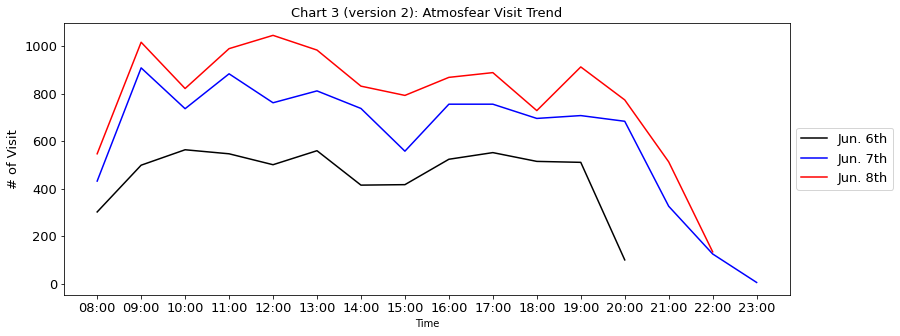

In [15]:
fig, ax = plt.subplots()

# Add lines to the graph in terms of date

ax = junsixth.plot(color = 'black', ax = ax, fontsize=13)
ax = junseventh.plot(color = 'blue', ax = ax, fontsize=13)
ax = juneighth.plot(color = 'red', ax = ax, fontsize=13)
legend_labels = ['Jun. 6th','Jun. 7th','Jun. 8th']
ax.legend(legend_labels,loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
ax.set_title("Chart 3 (version 2): Atmosfear Visit Trend", fontsize=13)
ax.set_xticks(junseventh.index)
ax.set_ylabel('# of Visit', fontsize=13)
fig.set_size_inches(13, 5)
fig.savefig('Chart 3 (version 2).png', bbox_inches='tight')

In [16]:
# Chart 4: A Box-and-Whisker Plot depicting total visits to the park's Kiddie Rides.
# Extract names of kiddie ride attractions

kiddie_ride_record = df_checkin.loc[df_checkin['Category'].str.contains('Kiddie Rides')]
kiddie_ride_record_count = kiddie_ride_record["AttractionName"].value_counts()
list_of_AttractionName = kiddie_ride_record['AttractionName'].unique()

visit_record_by_hour = pd.DataFrame()
for name in list_of_AttractionName:
    record = pd.DataFrame()
    record = df_checkin.loc[df_checkin['AttractionName'].str.contains(name)]
    record = record.sort_values(['timestamp'])
    record['timestamp'] = pd.to_datetime(record['timestamp'])

    group_visit_count = record.groupby(record.timestamp.dt.floor('1H')).count()
    group_visit_count = group_visit_count[['visitorID']]
    group_visit_count.columns = ['Visit']
    group_visit_count['Time'] = group_visit_count.index.time
    group_visit_count.set_index('Time', inplace=True, drop=True)
    group_visit_count[['Visit']].values

    visit_record_by_hour = pd.concat([visit_record_by_hour, pd.Series(group_visit_count['Visit'].values)], axis=1, ignore_index=True)

visit_record_by_hour.columns = list_of_AttractionName
median = visit_record_by_hour.median()
median.sort_values(ascending=True, inplace=True)
visit_record_by_hour = visit_record_by_hour[median.index]

Total visit of each kiddie ride: 
Type check:  <class 'list'>
[4062, 4022, 3963, 3925, 3922, 3877, 3759, 3747, 3747, 3640, 3597]


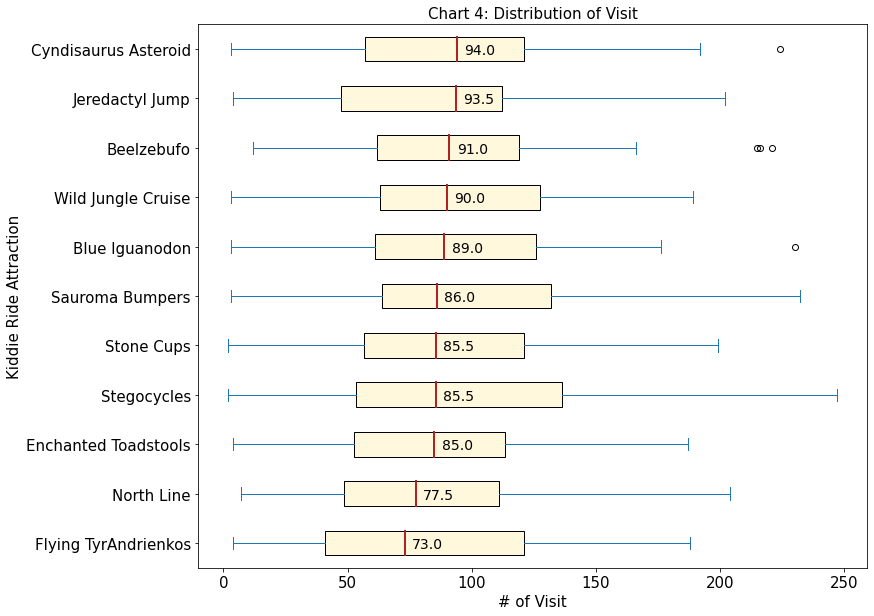

In [17]:
fig, ax = plt.subplots()

print("Total visit of each kiddie ride: ")
print("Type check: ", type(kiddie_ride_record_count.tolist()))
print(kiddie_ride_record_count.tolist())
ax = visit_record_by_hour[visit_record_by_hour.columns].plot(kind='box', 
                                                             ax = ax, 
                                                             vert=False, 
                                                             fontsize = 15, 
                                                             patch_artist=True,
                                                             medianprops=dict(linewidth=2, color='firebrick'),
                                                             boxprops=dict(facecolor='cornsilk'))
fig.set_size_inches(12, 10)
ax.set_title("Chart 4: Distribution of Visit", fontsize=15)
ax.set_xlabel('# of Visit', fontsize = 15)
ax.set_ylabel('Kiddie Ride Attraction', fontsize = 15)

# Annotate medians on graph
idx = 1
median.sort_values(ascending=False, inplace=True)
for xtick in median:
    ax.text(xtick+3, 11.9-idx, str(xtick), fontsize = 14)
    idx=idx+1
fig.savefig('Chart 4.png', bbox_inches='tight')